#  Data analysis for titanic
Notebook inspired from [Basic Workflow Introduction](https://www.kaggle.com/vikumsw/beginners-basic-workflow-introduction)  
The data is stored in dataset.csv

## Exploratory data analysis
Search correlation between features

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data cleaning

In [52]:
data = pd.read_csv("dataset.csv")
types = data.select_dtypes(include=['object']).copy()
print('Data before cleaning:')
display(data.head(2))
print('Memory before data cleaning {}'.format(data.memory_usage(deep=True).sum()))

data['sex'] = data['sex'].astype('category')
data['survived'] = data['survived'].astype('bool')
# Change Object columns to numeric
data[['age', 'ticket', 'fare', 'boat', 'body']] = data[['age', 'ticket', 'fare', 'boat', 'body']].apply(pd.to_numeric, errors='coerce')
print('Memory after data cleaning {}'.format(data.memory_usage(deep=True).sum()))

data['initial'] = data['name'].str.extract('([A-Za-z]+)\.')
data['initial'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

means = data.groupby('initial')['age'].mean().round(0)
data['age'] = np.where(data['age'].isnull(), means[data['initial']], data['age'])

data[['home', 'dest']] = data['home.dest'].str.split(' / ', expand=True, n=1)
data['dest']  = data['dest'].str.extract('([A-Z]+)$')

data.head(2)

Data before cleaning:


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"


Memory before data cleaning 890831
Memory after data cleaning 450528


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,initial,home,dest
0,1,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160.0,211.3375,B5,S,2.0,NaN,"St Louis, MO",Miss,"St Louis, MO",NaN
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781.0,151.5500,C22 C26,S,11.0,NaN,"Montreal, PQ / Chesterville, ON",Master,"Montreal, PQ",ON


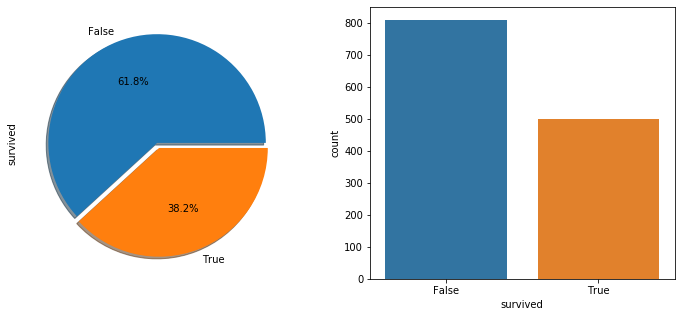

In [4]:
f, ax = plt.subplots(1,2,figsize=(12,5))
data['survived'].value_counts().plot.pie(explode=[0,0.05],autopct='{:1.1f}%'.format, ax=ax[0], shadow=True)
sns.countplot('survived', data=data, ax=ax[1])

## Sex 

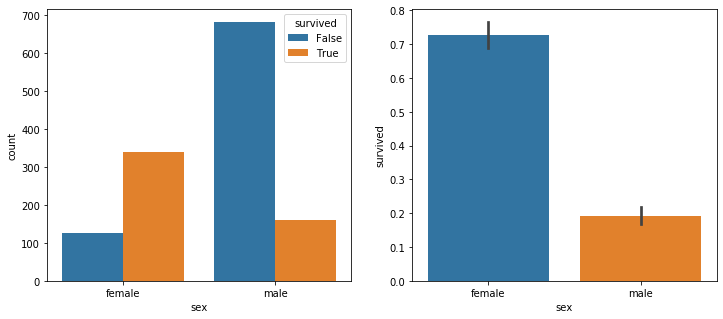

In [5]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.countplot(x='sex', hue='survived', data=data, ax=ax[0])
sns.barplot(data['sex'], data['survived'],ax=ax[1])

## Pclass

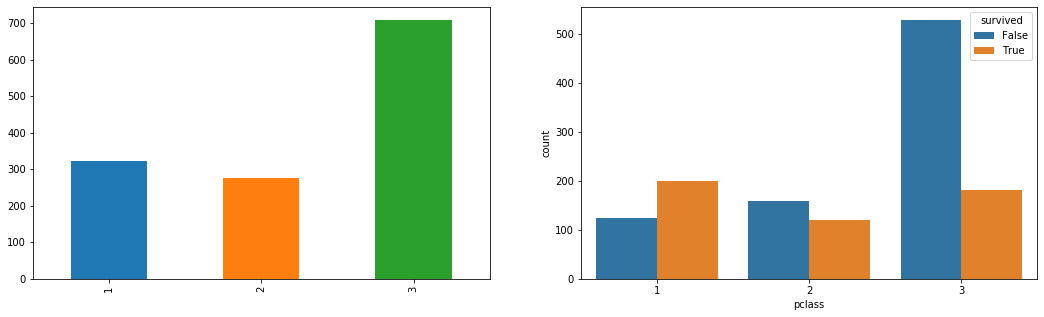

In [6]:
f,ax=plt.subplots(1,2,figsize=(18,5))
data['pclass'].value_counts(sort=False).plot.bar(ax=ax[0], color=['C0', 'C1', 'C2'])
sns.countplot('pclass', hue='survived', data=data, ax=ax[1])

## Age

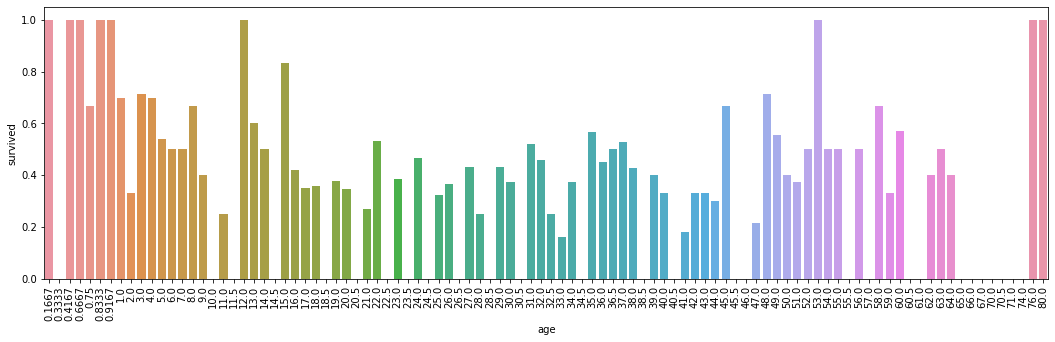

In [7]:
plt.figure(figsize=(18,5))
sns.barplot(data['age'], data['survived'], ci=None)
plt.xticks(rotation=90);

In [8]:
pd.crosstab(data['initial'], data['sex']).T.style.background_gradient('summer_r')

initial,Dona,Master,Miss,Mr,Mrs,Other
sex,,,,,,
female,1,0,265,1,199,0
male,0,61,0,769,0,13


In [9]:
data['age_bin'] = pd.cut(data['age'], 5)
data.groupby(['age_bin'])['survived'].mean().to_frame().style.background_gradient('summer_r')

,survived
age_bin,
"(0.0869, 16.133]",0.542254
"(16.133, 32.1]",0.394783
"(32.1, 48.067]",0.310782
"(48.067, 64.033]",0.443396
"(64.033, 80.0]",0.153846


## Embarked

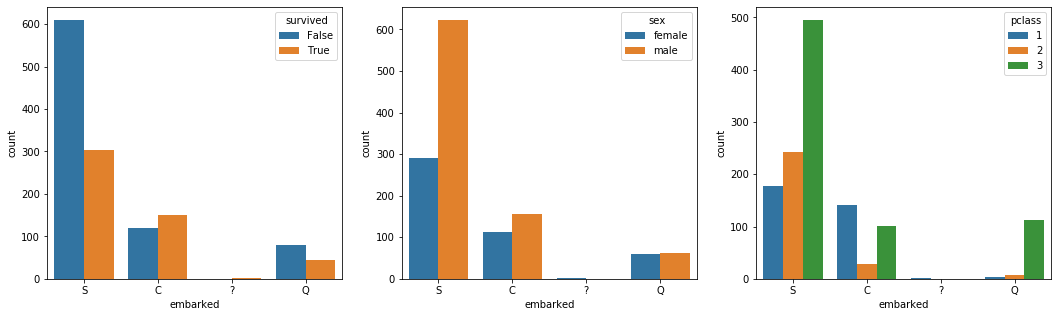

In [10]:
fig, ax = plt.subplots(1,3,figsize=(18, 5))
sns.countplot('embarked', hue='survived', data=data, ax=ax[0])
sns.countplot('embarked', hue='sex', data=data, ax=ax[1])
sns.countplot('embarked', hue='pclass', data=data, ax=ax[2])

## Fare

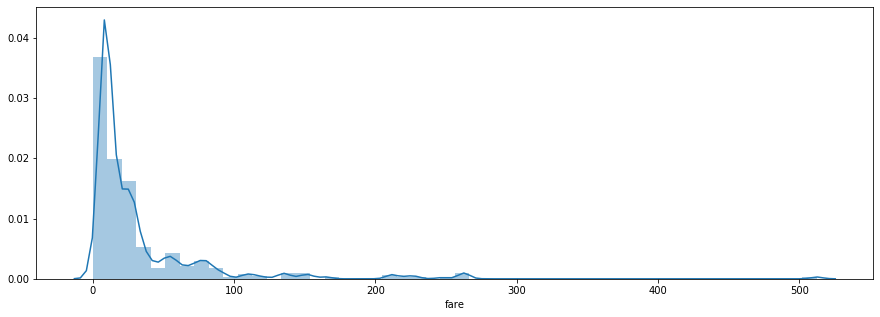

In [11]:
plt.figure(figsize=(15,5))
sns.distplot(data['fare'].dropna())

In [12]:
data['fare_bin'] = pd.qcut(data['fare'], 6)
data.groupby(['fare_bin'])['survived'].mean().to_frame().style.background_gradient('summer_r')

,survived
fare_bin,
"(-0.001, 7.775]",0.245763
"(7.775, 8.662]",0.192661
"(8.662, 14.454]",0.334975
"(14.454, 26.0]",0.413333
"(26.0, 53.1]",0.45283
"(53.1, 512.329]",0.668224


## Dest

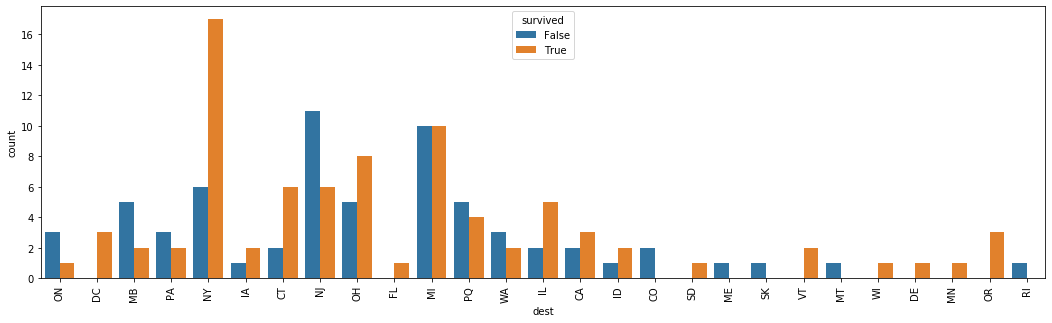

In [13]:
plt.figure(figsize=(18,5))
sns.countplot(data['dest'], hue=data['survived'])
plt.xticks(rotation=90);


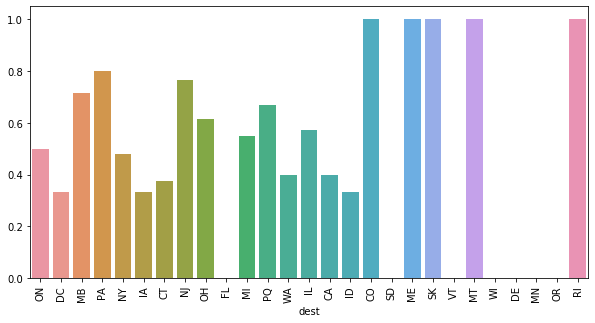

In [14]:
plt.figure(figsize=(10,5))
sliceData = data.loc[data['dest'] == 'MI']
sns.barplot('dest', data['sex'].cat.codes, data=data, ci=None)
plt.xticks(rotation=90);

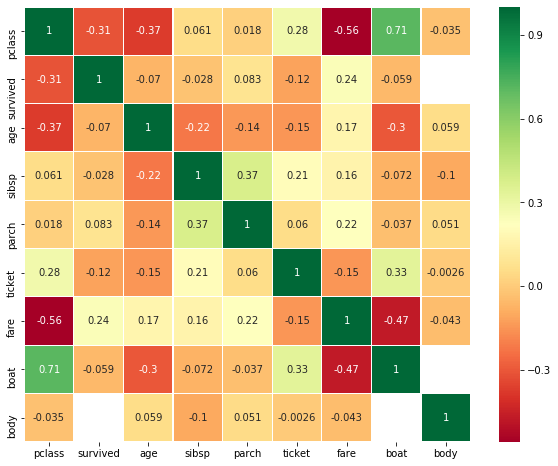

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn',linewidths=0.2)

## Converting features to model ready data

In [16]:
d = data.copy()
d['survived'] = d['survived'].astype('category').cat.codes
d['sex'] = d['sex'].cat.codes
d['embarked'] = d['embarked'].astype('category').cat.codes
d['initial'] = d['initial'].astype('category').cat.codes
d['fare_bin'] = d['fare_bin'].cat.codes
d['age_bin'] = d['age_bin'].cat.codes
d.drop(['name','age','sibsp','parch','ticket','fare','cabin','boat','body', 'home.dest', 'home', 'dest'],axis=1,inplace=True)
d.head()

,pclass,survived,sex,embarked,initial,age_bin,fare_bin
0,1,1,0,3,2,1,5
1,1,1,1,3,1,0,5
2,1,0,0,3,2,0,5
3,1,0,1,3,3,1,5
4,1,0,0,3,4,1,5


## Model 

In [17]:
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure

In [18]:
train_X, test_X = train_test_split(d, shuffle=True,  random_state=0, stratify=d['survived'])
train_Y=train_X.pop('survived')
test_Y = test_X.pop('survived')
X = d.drop('survived', axis=1)
Y = d['survived']

In [19]:
model = LogisticRegression(C=0.05, solver='liblinear')
model.fit(train_X, train_Y)
LR_prediction=model.predict(test_X)
print('The accuracy of the Logistic Regression model is \t',metrics.accuracy_score(LR_prediction,test_Y))

# Naive Bayes
model=GaussianNB()
model.fit(train_X,train_Y.values.ravel())
NB_prediction=model.predict(test_X)
print('The accuracy of the NaiveBayes model is\t\t\t',metrics.accuracy_score(NB_prediction,test_Y))

# Decision Tree
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
DT_prediction=model.predict(test_X)
print('The accuracy of the Decision Tree is \t\t\t',metrics.accuracy_score(DT_prediction,test_Y))

# Random Forest
model=RandomForestClassifier(n_estimators=500)
model.fit(train_X,train_Y)
RF_prediction=model.predict(test_X)
print('The accuracy of the Random Forests model is \t\t',metrics.accuracy_score(RF_prediction,test_Y))

The accuracy of the Logistic Regression model is 	 0.7804878048780488
The accuracy of the NaiveBayes model is			 0.7713414634146342
The accuracy of the Decision Tree is 			 0.8048780487804879
The accuracy of the Random Forests model is 		 0.7987804878048781


                         CV mean       std
LogisticRegression      0.623467  0.118123
GaussianNB              0.626525  0.121181
DecisionTreeClassifier  0.625756  0.114305
RandomForestClassifier  0.620410  0.116593


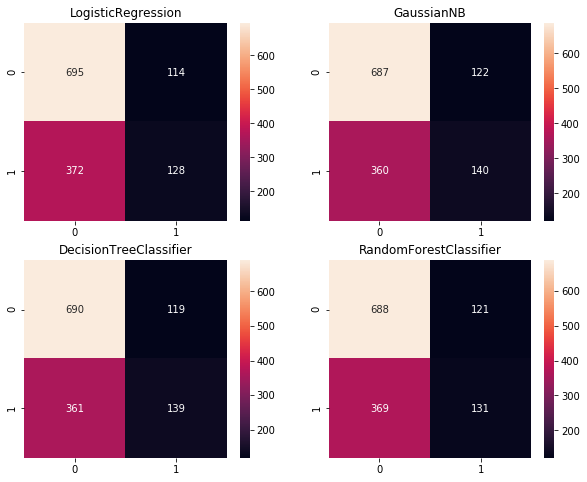

In [20]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix

f, axarr = plt.subplots(2,2, figsize=(10,8))

kfold = KFold(n_splits=2, random_state=22)
models = [LogisticRegression(C=0.05, solver='liblinear'), GaussianNB(), 
          DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100)]

cv_results = pd.DataFrame(columns= ['CV mean', 'std'])
for m, ax in zip(models, axarr.flat):
    result = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    result_df = pd.DataFrame([[result.mean(), result.std()]], columns=['CV mean', 'std'], index = [m.__class__.__name__])
    cv_results = cv_results.append(result_df)
    
    y_pred = cross_val_predict(model, X, Y, cv=kfold)
    ax.set_title(m.__class__.__name__)
    sns.heatmap(confusion_matrix(Y, y_pred), ax=ax, annot=True, fmt='2.0f')
    
print(cv_results)



In [21]:
from sklearn.model_selection import GridSearchCV

n_estimators = range(100,1000,100)
hyper = { 'n_estimators' : n_estimators }
gd = GridSearchCV(estimator=RandomForestClassifier(random_state=10), param_grid=hyper, verbose=True, cv=2)
gd.fit(X, Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    9.0s finished


0.6187929717341482
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)


The score is 0.8109756097560976


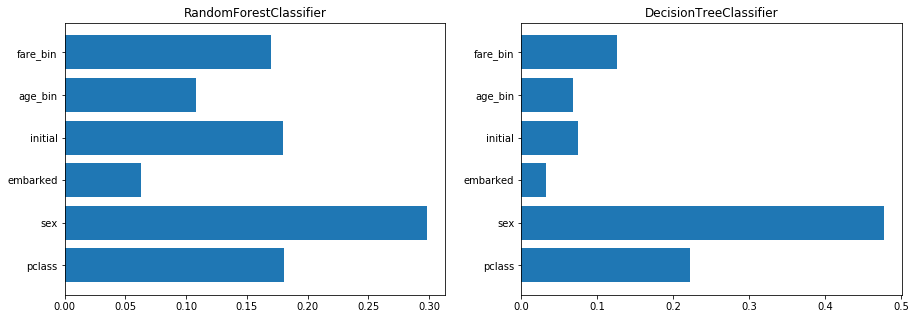

In [44]:
from sklearn.ensemble import VotingClassifier

f, axarr = plt.subplots(1,2,figsize=(15,5))
estimators=[('RFor',RandomForestClassifier(n_estimators=100,random_state=0)),
            ('DT',DecisionTreeClassifier())]

ensemble = VotingClassifier(estimators=estimators, voting='soft')
ensemble.fit(train_X, train_Y)
print(f'The score is {ensemble.score(test_X, test_Y)}')

for est, ax in zip(ensemble.estimators_, axarr.flat):
    ax.barh( train_X.columns, est.feature_importances_)
    ax.set_title(est.__class__.__name__)